投票结果：
C0: 54
C1: 43
C2: 103


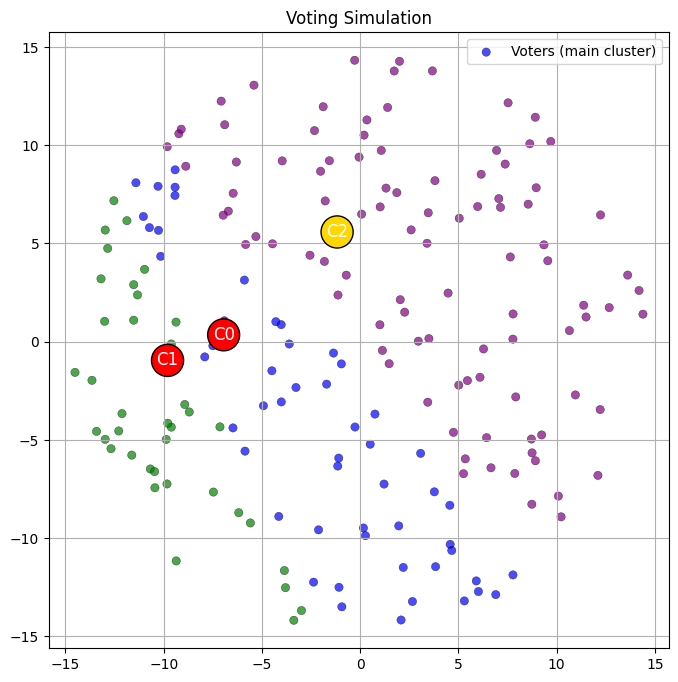

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class VotingSimulation:
    def __init__(self,
                 num_voters=100,
                 num_candidates=3,
                 center=np.array([0, 0]),
                 spread_radius=10,
                 dimension=2):
        """
        num_voters:       选民数量
        num_candidates:   候选人/提案数量（至少 2）
        center:           选民、候选人生成时的“理想中心点”（默认为 [0,0]）
        spread_radius:    生成时允许的最大“半径”范围
        dimension:        维度（目前只支持二维可视化）
        """
        self.num_voters = num_voters
        self.num_candidates = num_candidates
        self.center = np.array(center, dtype=float)
        self.spread_radius = spread_radius
        self.dimension = dimension

        # 初始化时生成选民和候选人位置
        self.voters = self._generate_voters()
        self.candidates = self._generate_candidates()
        self.votes = None  # 用于储存每个选民投票给哪个候选人（索引列表）

    def _generate_voters(self):
        """
        在一个圆形范围内生成 (num_voters - 1) 个随机点（角度均匀，半径 ~ sqrt(uniform)*spread_radius），
        然后第 N 个点作为补偿，使得所有点质心在 (0,0)，最后整体平移到 self.center。
        """
        # 随机生成 N-1 个点
        angles = np.random.uniform(0, 2 * np.pi, self.num_voters - 1)
        radii = np.sqrt(np.random.uniform(0, 1, self.num_voters - 1)) * self.spread_radius
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)
        raw = np.column_stack([x, y])  # 形状 (N-1, 2)

        # 补偿点 = －(前面所有点向量和)，保证质心在 (0,0)
        last = -np.sum(raw, axis=0)
        voters = np.vstack([raw, last]) + self.center  # 平移到 self.center
        return voters  # 形状 (N, 2)

    def _generate_candidates(self):
        """
        在同样的圆形范围内，均匀随机生成 num_candidates 个候选人坐标，
        最后平移到 self.center（候选人不需要质心补偿）。
        """
        angles = np.random.uniform(0, 2 * np.pi, self.num_candidates)
        radii = np.sqrt(np.random.uniform(0, 1, self.num_candidates)) * self.spread_radius
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)
        return np.column_stack([x, y]) + self.center  # 形状 (num_candidates, 2)

    def vote(self):
        """
        执行一次投票：每个选民计算到各候选人的距离，并将票投给最近的那个候选人。
        结果保存在 self.votes，这是一个长度为 num_voters 的整数数组（0..num_candidates-1）。
        """
        # 先生成一个 (num_voters, num_candidates) 的距离矩阵
        # voters[:, np.newaxis, :] 形状变成 (num_voters, 1, 2)
        # candidates[np.newaxis, :, :] 形状 (1, num_candidates, 2)
        # 这样广播后相减就可以得到每个选民对每个候选人的坐标差
        distances = np.linalg.norm(
            self.voters[:, np.newaxis, :] - self.candidates[np.newaxis, :, :],
            axis=2
        )  # 结果形状 (num_voters, num_candidates)

        # argmin 会返回沿 axis=1 最小值的索引，也就是每个选民投给谁（候选人的索引）
        self.votes = np.argmin(distances, axis=1)
        # 不再 return，用户只需调用 sim.vote() 即可完成投票动作。

    def get_result(self):
        """
        打印格式化后的投票结果（每一行 "C0: xx", "C1: yy", ...）。
        如果还没投票，就先执行一次 self.vote()。
        """
        if self.votes is None:
            self.vote()
        counts = Counter(self.votes)  # 统计每个候选人得票数
        print("投票结果：")
        for i in range(self.num_candidates):
            print(f"C{i}: {counts.get(i, 0)}")

    def plot(self):
        """
        将主要选民群体和候选人绘制出来，剔除少量极端离群选民：
          1. 先算出选民重心 voter_center = np.mean(self.voters, axis=0)。
          2. 计算每个选民到 voter_center 的距离 d_i，求取 d_i 的 95% 分位数 R95。
          3. 只把满足 d_i ≤ R95 的选民画出来。并用 R95 + margin 作为坐标轴范围。
          4. 最高票候选人用金色 (gold) 标记，其余候选人用红色 (red)。
        如果还没投票，就先执行一次 self.vote()。
        """
        if self.dimension != 2:
            print("目前仅支持二维可视化")
            return

        if self.votes is None:
            self.vote()

        # （A）计算选民重心
        voter_center = np.mean(self.voters, axis=0)  # 形如 [cx, cy]

        # （B）算出每个选民到重心的距离 d_i
        diffs = self.voters - voter_center  # 形状 (num_voters, 2)
        dists = np.linalg.norm(diffs, axis=1)  # 形状 (num_voters, )

        # （C）取 95% 分位数作为阈值 R95
        R95 = np.percentile(dists, 95)

        # 我们预留一点“小边距”，防止点正好在边界处被切掉
        margin = self.spread_radius * 0.05  # 半径的 5%

        # （D）确定要绘制的“主要选民”索引
        main_mask = dists <= R95  # 布尔数组，True 表示此选民在主要簇内

        plt.figure(figsize=(8, 8))

        # （E）绘制主要选民：根据投票结果着色
        # 预设一组循环颜色，示例：蓝、绿、紫、橙、青、品红……
        base_colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
        voter_colors = [base_colors[v % len(base_colors)]
                        for v in self.votes]  # len = num_voters

        # 只画 main_mask == True 的选民
        plt.scatter(self.voters[main_mask, 0],
                    self.voters[main_mask, 1],
                    c=np.array(voter_colors)[main_mask],
                    label='Voters (main cluster)',
                    alpha=0.7,
                    edgecolors='black',
                    linewidths=0.3)

        # （F）统计得票情况并找出“赢家”索引
        counts = Counter(self.votes)
        # 如果并列，这里会选索引最小的那个作为“赢家”
        winner = max(range(self.num_candidates), key=lambda i: counts.get(i, 0))

        # （G）绘制候选人：赢家金色、其它红色
        for idx, cand in enumerate(self.candidates):
            if idx == winner:
                color = 'gold'
                edgecolor = 'black'
                size = 180
            else:
                color = 'red'
                edgecolor = 'black'
                size = 150
            plt.scatter(cand[0], cand[1],
                        c=color,
                        edgecolors=edgecolor,
                        marker='X',
                        s=size,
                        linewidths=1.2,
                        zorder=5)
            # 在点上写上 “C0, C1, ...”
            plt.text(cand[0], cand[1], f'C{idx}',
                     fontsize=12, ha='center', va='center',
                     color='white',
                     bbox=dict(facecolor=color,
                               edgecolor='black',
                               boxstyle='circle,pad=0.3'),
                     zorder=6)

        # （H）设置坐标轴范围：以 voter_center 为中心，±(R95 + margin)
        lim = R95 + margin
        plt.xlim(voter_center[0] - lim, voter_center[0] + lim)
        plt.ylim(voter_center[1] - lim, voter_center[1] + lim)

        plt.title("Voting Simulation")
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.axis('equal')
        plt.show()


sim = VotingSimulation(num_voters=200, num_candidates=3, spread_radius=15)

sim.vote()
sim.get_result()
sim.plot()
